# Spectral normalization GAN with categorical projection conditioning
*Thomas Viehmann <tv@lernapparat.de>*

Spectral Normalization GANs are an exiting new regularization method that approximates the Wasserstein loss as a discriminator function. The authors also demonstrated the capabilities of a projection method for the discriminator - generating images for all 1000 imagenet (LSVRC2012) categories. We implement the smaller 64x64 pixel variant.
One of the crucial ingredients on the side of the Generator is a Conditional Batch Norm that enables learning a class-specific multiplier and bias.

This notebook
- is a straightforward adaptation of the [official chainer-based implementation in the 64x64 case](https://github.com/pfnet-research/sngan_projection)
- uses PyTorch's [spectral_norm](https://pytorch.org/docs/master/nn.html#torch.nn.utils.spectral_norm) implementation
- provides a custom Conditional Batch Norm modelled after the above official implementation but in a PyTorch-style way (see below)
- you need Python 3 and PyTorch / master, [including PR 9020](https://github.com/pytorch/pytorch/pull/9020)

**Acknowledgements:** I received many helpful hints on the PyTorch chat, in particular from Andy Brock, thanks! My own time was sponsored by [MathInf](https://mathinf.eu/), my ML consulting company.


First let's import something:

In [1]:
import matplotlib
try:
    %matplotlib inline
except: # if we are not in Jupyter, use the headless frontend
    matplotlib.use('Agg')
  
from matplotlib import pyplot
    
import IPython
import numpy
import time
import torch
import torchvision
import torch.utils.data


## Conditional Batch Norm

Here is the promised conditional batch norm. It aims to be compatible in functionality [to the SN-GAN author's version](https://github.com/pfnet-research/sngan_projection), the original reference seems to be [de Vries et. al., Modulating early visual processing by language](https://arxiv.org/abs/1707.00683).

It works pretty much like [regular batch norm](https://pytorch.org/docs/master/nn.html#torch.nn.BatchNorm2d) *except* that it has a per-class weight $\gamma$ and bias $\beta$.
In particular, note that the input mean and variance (to be "cleaned") and the running statistics are *not* class dependent. (Of course, one might wonder whether it should, but that is for another day...)

There also is a conditional instance norm, (which would resolve the input that the statistics being generated accross classes during training, but not during evaluation).

PyTorch usually initializes the `weight` with uniform random numbers. We instead use 1.0.

In [2]:
class BatchNorm2d(torch.nn.BatchNorm2d):
    def reset_parameters(self):
        self.reset_running_stats()
        if self.affine:
            self.weight.data.fill_(1.0)
            self.bias.data.zero_()


class CategoricalConditionalBatchNorm(torch.nn.Module):
    # as in the chainer SN-GAN implementation, we keep per-cat weight and bias
    def __init__(self, num_features, num_cats, eps=2e-5, momentum=0.1, affine=True,
                 track_running_stats=True):
        super().__init__()
        self.num_features = num_features
        self.num_cats = num_cats
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stats = track_running_stats
        if self.affine:
            self.weight = torch.nn.Parameter(torch.Tensor(num_cats, num_features))
            self.bias = torch.nn.Parameter(torch.Tensor(num_cats, num_features))
        else:
            self.register_parameter('weight', None)
            self.register_parameter('bias', None)
        if self.track_running_stats:
            self.register_buffer('running_mean', torch.zeros(num_features))
            self.register_buffer('running_var', torch.ones(num_features))
            self.register_buffer('num_batches_tracked', torch.tensor(0, dtype=torch.long))
        else:
            self.register_parameter('running_mean', None)
            self.register_parameter('running_var', None)
            self.register_parameter('num_batches_tracked', None)
        self.reset_parameters()

    def reset_running_stats(self):
        if self.track_running_stats:
            self.running_mean.zero_()
            self.running_var.fill_(1)
            self.num_batches_tracked.zero_()

    def reset_parameters(self):
        self.reset_running_stats()
        if self.affine:
            self.weight.data.fill_(1.0)
            self.bias.data.zero_()

    def forward(self, input, cats):
        exponential_average_factor = 0.0

        if self.training and self.track_running_stats:
            self.num_batches_tracked += 1
            if self.momentum is None:  # use cumulative moving average
                exponential_average_factor = 1.0 / self.num_batches_tracked.item()
            else:  # use exponential moving average
                exponential_average_factor = self.momentum

        out = torch.nn.functional.batch_norm(
            input, self.running_mean, self.running_var, None, None,
            self.training or not self.track_running_stats,
            exponential_average_factor, self.eps)
        if self.affine:
            shape = [input.size(0), self.num_features] + (input.dim() - 2) * [1]
            weight = self.weight.index_select(0, cats).view(shape)
            bias = self.bias.index_select(0, cats).view(shape)
            out = out * weight + bias
        return out

    def extra_repr(self):
        return '{num_features}, num_cats={num_cats}, eps={eps}, momentum={momentum}, affine={affine}, ' \
               'track_running_stats={track_running_stats}'.format(**self.__dict__)


## Generator

With that, we can define the generator.

In [3]:
class ResGenBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=None, ksize=3, pad=1,
                 activation=torch.nn.functional.relu, upsample=False, n_classes=0):
        super().__init__()
        self.activation = activation
        self.upsample = upsample
        self.learnable_sc = in_channels != out_channels or upsample
        hidden_channels = out_channels if hidden_channels is None else hidden_channels
        self.n_classes = n_classes
        self.c1 = torch.nn.Conv2d(in_channels, hidden_channels, ksize, padding=pad)
        torch.nn.init.xavier_uniform_(self.c1.weight, gain=(2**0.5))
        torch.nn.init.zeros_(self.c1.bias)
        self.c2 = torch.nn.Conv2d(hidden_channels, out_channels, ksize, padding=pad)
        torch.nn.init.xavier_uniform_(self.c2.weight, gain=(2**0.5))
        torch.nn.init.zeros_(self.c2.bias)
        if n_classes > 0:
            self.b1 = CategoricalConditionalBatchNorm(in_channels, n_classes)
            self.b2 = CategoricalConditionalBatchNorm(hidden_channels, n_classes)
        else:
            self.b1 = BatchNorm2d(in_channels)
            self.b2 = BatchNorm2d(hidden_channels)
        if self.learnable_sc:
            self.c_sc = torch.nn.Conv2d(in_channels, out_channels, 1, padding=0)
            torch.nn.init.xavier_uniform_(self.c_sc.weight)
            torch.nn.init.zeros_(self.c_sc.bias)

    def forward(self, x, y=None):
        h = x
        h = self.b1(h, y) if y is not None else self.b1(h)
        h = self.activation(h)
        if self.upsample:
            h = torch.nn.functional.upsample(h, scale_factor=2)
        h = self.c1(h)
        h = self.b2(h, y) if y is not None else self.b2(h)
        h = self.activation(h)
        h = self.c2(h)
        if self.learnable_sc:
            if self.upsample:
                x = torch.nn.functional.upsample(x, scale_factor=2)
            sc = self.c_sc(x)
        else:
            sc = x
        return h + sc

class ResNetGenerator(torch.nn.Module):
    def __init__(self, ch=64, dim_z=128, bottom_width=4, activation=torch.nn.functional.relu, n_classes=0):
        super().__init__()
        self.bottom_width = bottom_width
        self.activation = activation
        self.dim_z = dim_z
        self.n_classes = n_classes
        self.l1 = torch.nn.Linear(dim_z, (bottom_width ** 2) * ch * 16)
        torch.nn.init.xavier_uniform_(self.l1.weight)
        torch.nn.init.zeros_(self.l1.bias)
        self.block2 = ResGenBlock(ch * 16, ch * 8, activation=activation, upsample=True, n_classes=n_classes)
        self.block3 = ResGenBlock(ch * 8, ch * 4, activation=activation, upsample=True, n_classes=n_classes)
        self.block4 = ResGenBlock(ch * 4, ch * 2, activation=activation, upsample=True, n_classes=n_classes)
        self.block5 = ResGenBlock(ch * 2, ch, activation=activation, upsample=True, n_classes=n_classes)
        self.b6 = BatchNorm2d(ch)
        self.l6 = torch.nn.Conv2d(ch, 3, 3, stride=1, padding=1)
        torch.nn.init.xavier_uniform_(self.l6.weight)
        torch.nn.init.zeros_(self.l6.bias)

    def forward(self, batchsize=64, z=None, y=None, DEBUG=None, debugname="generator"):
        anyparam = next(self.parameters())
        if z is None:
            z = torch.randn(batchsize, self.dim_z, dtype=anyparam.dtype, device=anyparam.device)
        if y is None and self.n_classes > 0:
            y = torch.randint(0, self.n_classes, (batchsize,), device=anyparam.device, dtype=torch.long)
        if (y is not None) and z.shape[0] != y.shape[0]:
            raise Exception('z.shape[0] != y.shape[0], z.shape[0]={}, y.shape[0]={}'.format(z.shape[0], y.shape[0]))
        h = z
        h = self.l1(h)
        h = h.reshape(h.shape[0], -1, self.bottom_width, self.bottom_width)
        h = self.block2(h, y)
        h = self.block3(h, y)
        h = self.block4(h, y)
        h = self.block5(h, y)
        h = self.b6(h)
        h = self.activation(h)
        h = torch.tanh(self.l6(h))
        return h


## Discriminator

And the discriminator. So one of the subtle differences between ResDisBlock and the ResDisOptimizedBlock is that ResDisBlock starts with an activation - even though these look like they could be both covered by a single module...

In [4]:
class ResDisBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=None, ksize=3, pad=1,
                 activation=torch.nn.functional.relu, downsample=False):
        super().__init__()
        self.activation = activation
        self.downsample = downsample
        self.learnable_sc = (in_channels != out_channels) or downsample
        hidden_channels = in_channels if hidden_channels is None else hidden_channels
        self.c1 = torch.nn.Conv2d(in_channels, hidden_channels, ksize, padding=pad)
        torch.nn.init.xavier_uniform_(self.c1.weight, gain=(2**0.5))
        torch.nn.init.zeros_(self.c1.bias)
        torch.nn.utils.spectral_norm(self.c1)
        self.c2 = torch.nn.Conv2d(hidden_channels, out_channels, ksize, padding=pad)
        torch.nn.init.xavier_uniform_(self.c2.weight, gain=(2**0.5))
        torch.nn.init.zeros_(self.c2.bias)
        torch.nn.utils.spectral_norm(self.c2)
        if self.learnable_sc:
            self.c_sc = torch.nn.Conv2d(in_channels, out_channels, 1, padding=0)
            torch.nn.init.xavier_uniform_(self.c_sc.weight)
            torch.nn.init.zeros_(self.c_sc.bias)
            torch.nn.utils.spectral_norm(self.c_sc)

    def forward(self, x):
        h = x
        h = self.activation(h)
        h = self.c1(h)
        h = self.activation(h)
        h = self.c2(h)
        if self.downsample:
            h = torch.nn.functional.avg_pool2d(h, 2)
        if self.learnable_sc:
            sc = self.c_sc(x)
            if self.downsample:
                sc = torch.nn.functional.avg_pool2d(sc, 2)
        else:
            sc = x
        return h + sc

class ResDisOptimizedBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, ksize=3, pad=1, activation=torch.nn.functional.relu):
        super().__init__()
        self.activation = activation
        self.c1 = torch.nn.Conv2d(in_channels, out_channels, ksize, padding=pad)
        torch.nn.init.xavier_uniform_(self.c1.weight, gain=(2**0.5))
        torch.nn.init.zeros_(self.c1.bias)
        torch.nn.utils.spectral_norm(self.c1)
        self.c2 = torch.nn.Conv2d(out_channels, out_channels, ksize, padding=pad)
        torch.nn.init.xavier_uniform_(self.c2.weight, gain=(2**0.5))
        torch.nn.init.zeros_(self.c2.bias)
        torch.nn.utils.spectral_norm(self.c2)
        self.c_sc = torch.nn.Conv2d(in_channels, out_channels, 1, padding=0)
        torch.nn.init.xavier_uniform_(self.c_sc.weight)
        torch.nn.init.zeros_(self.c_sc.bias)
        torch.nn.utils.spectral_norm(self.c_sc)

    def forward(self, x):
        h = x
        h = self.c1(h)
        h = self.activation(h)
        h = self.c2(h)
        h = torch.nn.functional.avg_pool2d(h, 2)
        sc = self.c_sc(x)
        sc = torch.nn.functional.avg_pool2d(sc, 2)
        return h + sc

class SNResNetProjectionDiscriminator(torch.nn.Module):
    def __init__(self, ch=64, n_classes=0, activation=torch.nn.functional.relu):
        super().__init__()
        self.activation = activation
        self.block1 = ResDisOptimizedBlock(3, ch)
        self.block2 = ResDisBlock(ch, ch * 2, activation=activation, downsample=True)
        self.block3 = ResDisBlock(ch * 2, ch * 4, activation=activation, downsample=True)
        self.block4 = ResDisBlock(ch * 4, ch * 8, activation=activation, downsample=True)
        self.block5 = ResDisBlock(ch * 8, ch * 16, activation=activation, downsample=True)
        self.l6 = torch.nn.Linear(ch * 16, 1)
        torch.nn.init.xavier_uniform_(self.l6.weight)
        torch.nn.init.zeros_(self.l6.bias)
        torch.nn.utils.spectral_norm(self.l6)

        if n_classes > 0:
            self.l_y = torch.nn.Embedding(n_classes, ch * 16)
            torch.nn.init.xavier_uniform_(self.l_y.weight)
            torch.nn.utils.spectral_norm(self.l_y)

    def forward(self, x, y=None):
        h = x
        h = self.block1(h)
        h = self.block2(h)
        h = self.block3(h)
        h = self.block4(h)
        h = self.block5(h)
        h = self.activation(h)
        h = h.sum([2, 3])
        output = self.l6(h)
        if y is not None:
            w_y = self.l_y(y)
            output = output + (w_y * h).sum(dim=1, keepdim=True)
        return output


## Putting it together

Let's have some hyperparameters.

In [5]:
batchsize = 64
num_iterations = 250000
iterations_decay_start = 200000
seed = 0
display_interval = 1000
snapshot_interval = 10000
evaluation_interval = 1000
init_lr = 0.0002
num_discriminator_iter = 5
num_classes = 143 # cats and dogs
augmentation = True
train_dir = './cats_and_dogs/' # I just used the corresponding folders of the classes from the original imagenet set
device = torch.device('cuda')

In [6]:
gen = ResNetGenerator(n_classes=num_classes)
gen.to(device)
opt_gen = torch.optim.Adam(params=gen.parameters(), lr=init_lr, betas=(0.0, 0.9)) # betas from chainer SNGAN

dis = SNResNetProjectionDiscriminator(n_classes=num_classes)
dis.to(device)
opt_dis = torch.optim.Adam(params=dis.parameters(), lr=init_lr, betas=(0.0, 0.9))

## Dataloader

We use the imagenet dataloader from `torchvision`. We resize to 64x64.
I have tried to stay close to the original implementation.

In [7]:
# This intends to reproduce the preprocessing in the chainer SNGAN repository with and without augmentation 
if augmentation:
    transforms = torchvision.transforms.Compose(
        [torchvision.transforms.Resize(256),
         torchvision.transforms.RandomCrop(int(256*0.9)),
         torchvision.transforms.Resize(64),
         torchvision.transforms.RandomHorizontalFlip(),
         torchvision.transforms.ToTensor(),
         torchvision.transforms.Lambda(lambda x: x*(255./128.)-1+torch.rand(*x.shape)/128.)
        ])
else:
    transforms = torchvision.transforms.Compose(
        [torchvision.transforms.Resize(256),
         torchvision.transforms.CenterCrop(256),
         torchvision.transforms.Resize(64),
         torchvision.transforms.ToTensor(),
         torchvision.transforms.Lambda(lambda x: x*(255./128.)-1+torch.rand(*x.shape)/128.)
        ])

train_dataset = torchvision.datasets.ImageFolder(train_dir, transforms)

def endless_train_dl(dl):
    while True:
        for b in dl:
            yield b

train_dl_ = torch.utils.data.DataLoader(train_dataset, batch_size=batchsize, shuffle=True, pin_memory=True, num_workers=4)
train_dl = endless_train_dl(train_dl_)


## Chicken!

(if you are using the full imagenet)

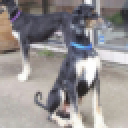

In [8]:
img = None
if matplotlib.get_backend().lower() != 'agg':
    im, lab = train_dataset[11000]
    img = torchvision.transforms.functional.to_pil_image(im*0.5+0.5)
    img = img.resize((128,128))
img

## Training

Training promises to take around 65 hours on my computer.

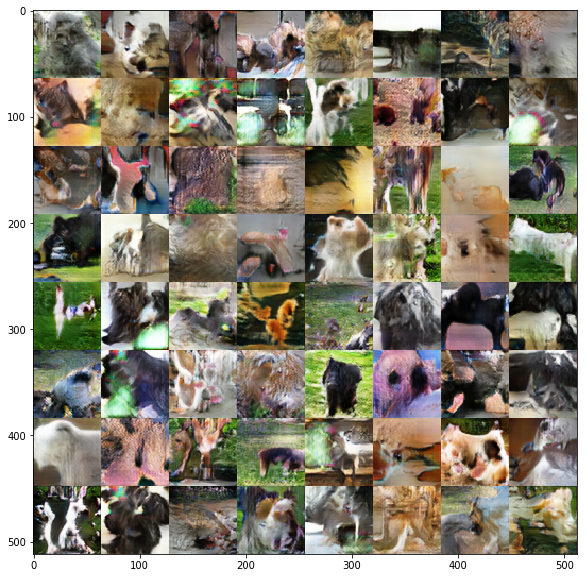

it_nr 4000 i 4 loss_dis 1.3410093784332275 loss_gen -0.45257145166397095
it_nr 4000 / 250000 time per it 0.9507223594188691 remaining 64:57:57


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2555904 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


In [ ]:
time1 = time.time()
for it_nr in range(num_iterations):
    for i in range(num_discriminator_iter):
        if i == 0:
            z_fake = torch.randn(batchsize, gen.dim_z, dtype=torch.float, device=device)
            y_fake = torch.randint(0, gen.n_classes, (batchsize,), device=device, dtype=torch.long)
            x_fake = gen(batchsize, y=y_fake, z=z_fake)
            dis_fake = dis(x_fake, y=y_fake)
            loss_gen = -dis_fake.mean()
            opt_gen.zero_grad()
            loss_gen.backward()
            opt_gen.step()

        im, lab = next(train_dl)
        x_real = im.to(device)
        y_real = lab.to(device)
        
        batchsize = x_real.size(0)

        y_fake = torch.randint(0, gen.n_classes, (batchsize,), device=device, dtype=torch.long)
        with torch.no_grad():
            x_fake = gen(batchsize, y=y_fake).detach()
        
        dis_real = dis(x_real, y=y_real)
        dis_fake = dis(x_fake, y=y_fake)
        loss_dis = (torch.nn.functional.relu(1. - dis_real).mean() +
                    torch.nn.functional.relu(1. + dis_fake).mean())
        opt_dis.zero_grad()
        loss_dis.backward()
        opt_dis.step()

    if it_nr % display_interval == 0:
        IPython.display.clear_output(True)
        pyplot.figure(figsize=(10,10))
        pyplot.imshow(numpy.transpose(x_fake.cpu().numpy().reshape(8,8,3,64,64), (0,3,1,4,2)).reshape(8*64,8*64,3)*0.5+0.5)
        pyplot.savefig(f"sample_{it_nr:07d}")
        pyplot.show()
    if it_nr % display_interval == 0:
        print('it_nr',it_nr, 'i', i, 'loss_dis', loss_dis.item(), 'loss_gen', loss_gen.item())
        time2 = time.time()
        remaining = int((time2 - time1)* (num_iterations - it_nr) / float(display_interval))
        print ("it_nr", it_nr, "/", num_iterations, "time per it", (time2 - time1) / float(display_interval),
               "remaining {:02d}:{:02d}:{:02d}".format(remaining // 3600, remaining // 60 % 60, remaining % 60))
        time1 = time2
    if it_nr % snapshot_interval == 0:
        print ("saving snapshot")
        torch.save([dis.state_dict(), gen.state_dict()], f"snapshot_{it_nr}.pt")


In [10]:
if matplotlib.get_backend().lower() == 'agg': # below is not for non-interactive
    import sys
    sys.exit(0)

## Sampling


In [11]:
gen = ResNetGenerator(dim_z=128, bottom_width=4, ch=64, n_classes=num_classes)
dis = SNResNetProjectionDiscriminator(ch=64, n_classes=num_classes)


[dis_sd, gen_sd] = torch.load('./snapshot_0.pt')
dis.load_state_dict(dis_sd)
gen.load_state_dict(gen_sd)

In [ ]:
y_fake = torch.randint(0, gen.n_classes, (batchsize,), device=next(gen.parameters()).device, dtype=torch.long)
x_fake = gen(batchsize, y=y_fake)

img = torchvision.transforms.functional.to_pil_image((x_fake.view(8,8,3,64,64).permute(2,0,3,1,4).reshape(3, 8*64,8*64)*0.5+0.5).cpu())
img.save("sample_manual.jpg")
img

I hope you enjoyed this notebook. I would love to hear from you <tv@lernapparat.de>.

*Thomas Viehmann*